In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

df = pd.read_csv('../data/data-final.csv')

# remove header
df = df[2:]
head = df.head(0)

drug = df[df['1_qs-drug-ans'].apply(lambda x: isinstance(x, str))]
pm = df[df['1_qs-pm-ans'].apply(lambda x: isinstance(x, str))]
shoplift = df[df['1_qs-shoplift-ans'].apply(lambda x: isinstance(x, str))]

sources_df = {
    'drug': drug,
    'pm': pm,
    'shoplift': shoplift
}

In [2]:
pd.set_option('future.no_silent_downcasting', True)

conditions = ['control', 'honest summary', 'honest chatbot', 'misleading summary', 'misleading chatbot']
sources = ['drug', 'pm', 'shoplift']


def sum_ans(df, condition, type="false"):
    real_col = [f"{i}_qs-{source}-ans" for i in [*range(1,11)]]
    fake_col = [f"{i}_qs-{source}-ans" for i in [*range(11,16)]]
    
    yes = { "1": 1, "2": 0, "3": 0}
    unsure = { "1": 0, "2": 1, "3": 0}
    no = { "1": 0, "2": 0, "3": 1}
    
    types = {
        "true": [yes,no],
        "unsure": [unsure,unsure],
        "false": [no,yes]
    }
    
    df_real = df[df['condition'] == condition][real_col].replace(types[type][0])
    df_fake = df[df['condition'] == condition][fake_col].replace(types[type][1])
    df_overall = df_real.sum(axis=1) + df_fake.sum(axis=1)
        
    print(f"{condition} -> mean: {"{:.2f}".format(df_overall.mean())} | raw: {df_overall.tolist()}")
    return [df_real.sum(axis=1), df_fake.sum(axis=1), df_overall]
    
overall = {
    'control': [[], [], []],
    'honest summary': [[], [], []],
    'honest chatbot': [[], [], []],
    'misleading summary': [[], [], []],
    'misleading chatbot': [[], [], []]   
}

for source in sources:
    print(source)
    for condition in conditions:
        score = sum_ans(sources_df[source], condition)
        for i in range(3):
            overall[condition][i] += score[i].tolist()
        # overall[condition] += score.tolist()[0:24]
    print()

drug
control -> mean: 1.92 | raw: [3, 2, 5, 0, 2, 0, 1, 0, 2, 4, 1, 3]
honest summary -> mean: 1.92 | raw: [4, 0, 0, 4, 2, 0, 2, 1, 5, 2, 0, 0, 5]
honest chatbot -> mean: 0.67 | raw: [2, 0, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0]
misleading summary -> mean: 1.75 | raw: [1, 0, 5, 2, 2, 1, 2, 3, 0, 0, 2, 3]
misleading chatbot -> mean: 3.36 | raw: [4, 3, 3, 1, 2, 5, 5, 0, 1, 5, 4, 5, 5, 4]

pm
control -> mean: 2.08 | raw: [2, 2, 2, 2, 3, 3, 0, 0, 3, 6, 1, 2, 1]
honest summary -> mean: 2.92 | raw: [4, 5, 5, 3, 5, 1, 0, 5, 2, 1, 0, 4]
honest chatbot -> mean: 1.36 | raw: [1, 3, 1, 0, 2, 1, 1, 2, 0, 1, 3]
misleading summary -> mean: 2.71 | raw: [4, 1, 1, 7, 3, 1, 1, 4, 3, 3, 0, 3, 4, 3]
misleading chatbot -> mean: 3.50 | raw: [4, 2, 3, 6, 4, 4, 2, 5, 3, 2, 5, 2]

shoplift
control -> mean: 1.33 | raw: [1, 0, 1, 5, 3, 1, 2, 1, 0, 0, 1, 1]
honest summary -> mean: 1.38 | raw: [0, 2, 5, 1, 0, 0, 2, 1, 2, 0, 2, 2, 1]
honest chatbot -> mean: 1.92 | raw: [0, 2, 3, 0, 0, 1, 4, 5, 2, 0, 0, 6]
misleading summary 

true

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.7785552369818385), pvalue=np.float64(4.964474907991301e-06))
honest summary => ShapiroResult(statistic=np.float64(0.7586926862907507), pvalue=np.float64(1.6689011925572375e-06))
honest chatbot => ShapiroResult(statistic=np.float64(0.8541871538095285), pvalue=np.float64(0.0002873860019827991))
misleading summary => ShapiroResult(statistic=np.float64(0.8678563469330024), pvalue=np.float64(0.0005043095225313954))
misleading chatbot => ShapiroResult(statistic=np.float64(0.841987047871864), pvalue=np.float64(5.782521674313821e-05))

KRUSKAL
KruskalResult(statistic=np.float64(19.87380832394531), pvalue=np.float64(0.0005288734453909202))

DUNN
          1         2         3         4         5
1  1.000000  0.987147  0.255073  0.072421  0.000164
2  0.987147  1.000000  0.245502  0.068117  0.000138
3  0.255073  0.245502  1.000000  0.521413  0.010630
4  0.072421  0.068117  0.521413  1.000000  0.055973
5  0.000164  0.000138  0.010

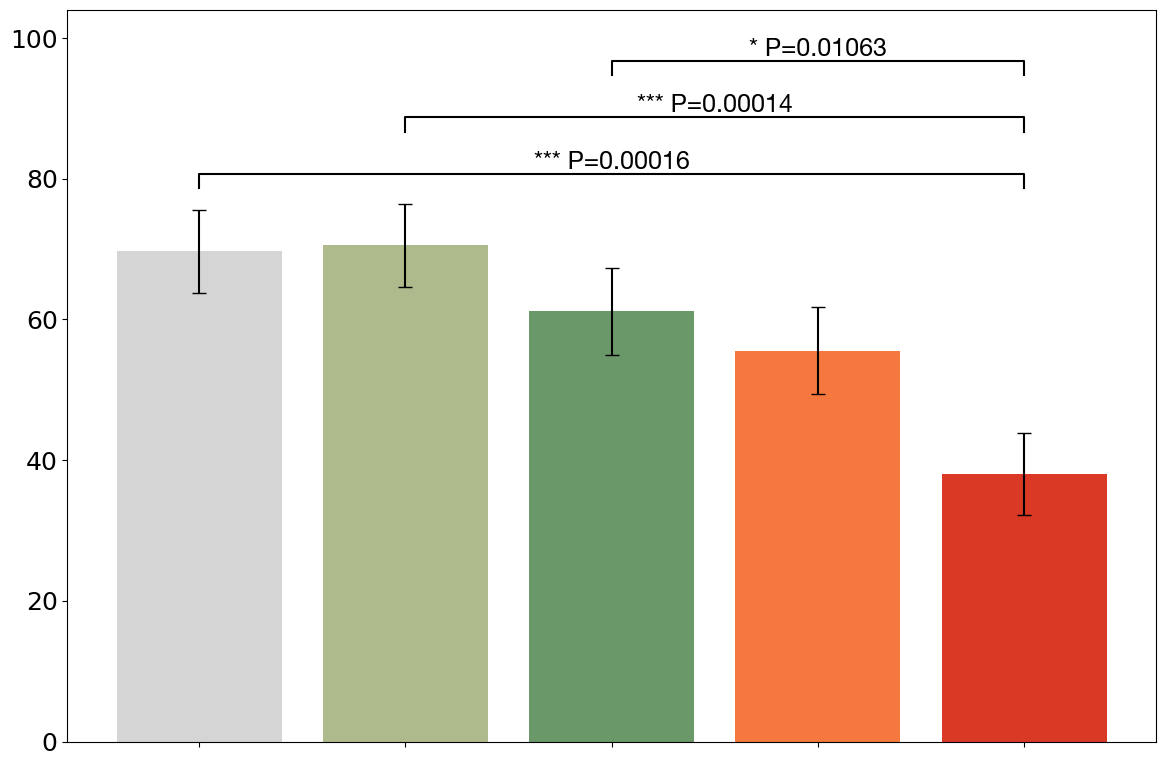

unsure

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.7009108088757185), pvalue=np.float64(2.229223470191973e-07))
honest summary => ShapiroResult(statistic=np.float64(0.5610486093557627), pvalue=np.float64(1.7731291595939458e-09))
honest chatbot => ShapiroResult(statistic=np.float64(0.7394175720998155), pvalue=np.float64(1.6182831637830407e-06))
misleading summary => ShapiroResult(statistic=np.float64(0.6785855908878361), pvalue=np.float64(1.3254801853664997e-07))
misleading chatbot => ShapiroResult(statistic=np.float64(0.7260966939022158), pvalue=np.float64(2.681992327252398e-07))

KRUSKAL
KruskalResult(statistic=np.float64(6.937323940104541), pvalue=np.float64(0.13923767112514096))

DUNN
          1         2         3         4         5
1  1.000000  0.086342  0.606209  0.725866  0.697354
2  0.086342  1.000000  0.027137  0.039782  0.032343
3  0.606209  0.027137  1.000000  0.867956  0.887154
4  0.725866  0.039782  0.867956  1.000000  0.977008
5  0.697354  0.032343  0.

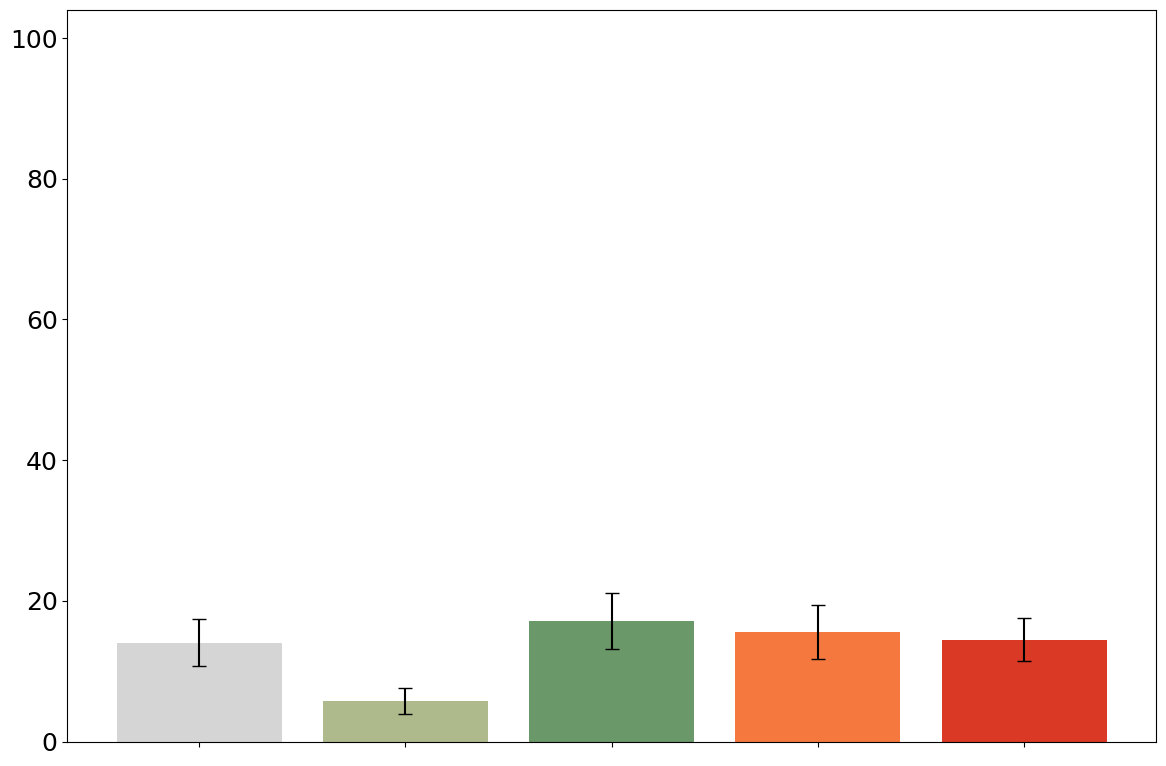

false

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.6933969250990273), pvalue=np.float64(1.6961793363806335e-07))
honest summary => ShapiroResult(statistic=np.float64(0.7106886746784548), pvalue=np.float64(2.458980128353013e-07))
honest chatbot => ShapiroResult(statistic=np.float64(0.7437720747929905), pvalue=np.float64(1.9184324489058167e-06))
misleading summary => ShapiroResult(statistic=np.float64(0.8181846671794503), pvalue=np.float64(3.820907780453903e-05))
misleading chatbot => ShapiroResult(statistic=np.float64(0.8895280489018668), pvalue=np.float64(0.0009612273631711174))

KRUSKAL
KruskalResult(statistic=np.float64(19.65956872701183), pvalue=np.float64(0.0005829062365899949))

DUNN
          1         2         3         4         5
1  1.000000  0.429842  0.385391  0.081308  0.000051
2  0.429842  1.000000  0.924048  0.331746  0.001053
3  0.385391  0.924048  1.000000  0.391507  0.001872
4  0.081308  0.331746  0.391507  1.000000  0.024591
5  0.000051  0.001053  0.

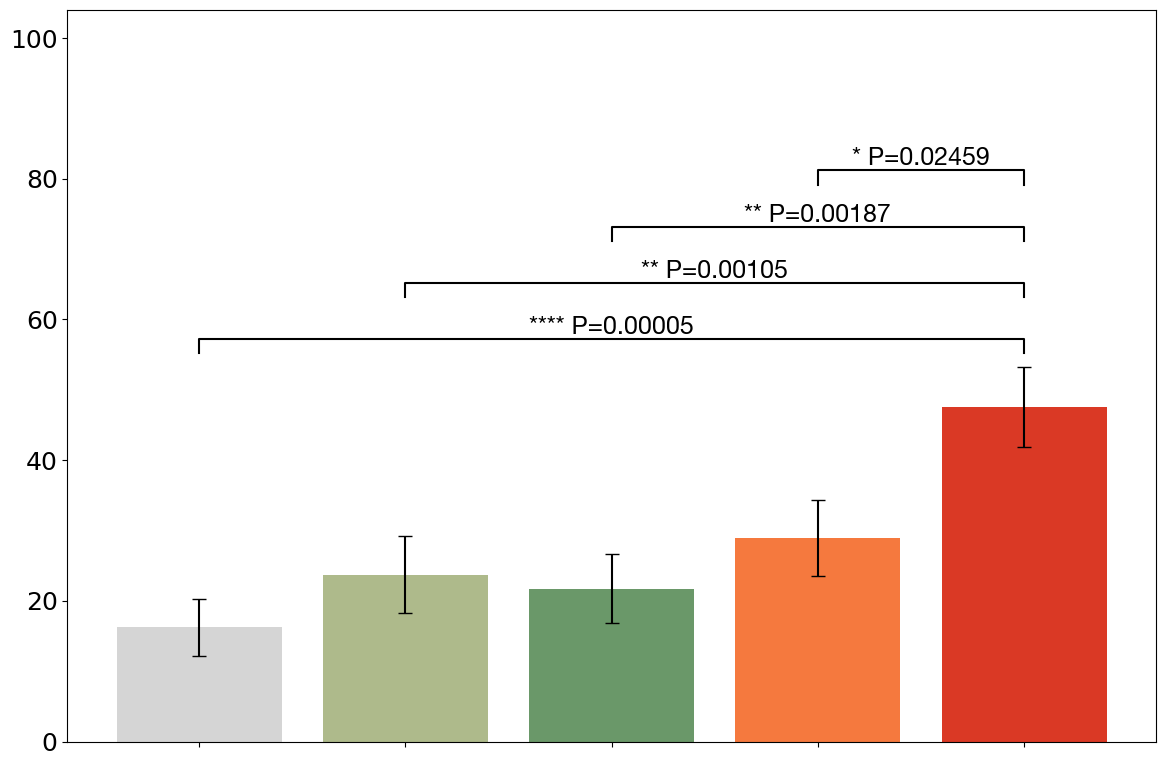

In [5]:
import numpy as np
from scipy.stats import shapiro, kruskal
from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=18)

def prepare(groups):
    means = []
    errors = []
    sds = []

    for group in groups:
        mean = np.mean(groups[group])

        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = np.std(groups[group])
        error = np.std(groups[group]) / np.sqrt(len(groups[group]))
        means.append(mean)
        sds.append(std)
        errors.append(error)
        
        print(f"{group}: \\textit{{M}}={"{:.3f}".format(mean)}, \\textit{{err}}={"{:.3f}".format(error)}, \\textit{{s.d.}}={"{:.3f}".format(std)};")

    return [means, errors, sds]

def plot(data, sig, limit=100):
    ordered_labels = ['', '', '', '', '']
    colors = ["#D5D5D5", "#AEBA8B", "#6A9869", "#F5793E", "#DA3925"]

    # X positions
    x_pos = np.arange(len(conditions))

    # *    P ≤ 0.05
    # **   P ≤ 0.01
    # ***  P ≤ 0.001
    # **** P ≤ 0.0001

    significance_values = []
    for s in sig:
        [val, ii, jj] = s
        star = "*"
        if(val <= 0.0001): star = "****"
        elif(val <= 0.001): star = "***"
        elif(val <= 0.01): star = "**"
        significance_values.append(((ii-1,jj-1), f"{star} P={"{:.5f}".format(val)}"))

    [means, errors, sds] = prepare(data)

    # Creating the bar plot with error bars
    plt.figure(figsize=(12, 7 if limit == 30 else 8))
    plt.bar(x_pos, means, yerr=errors, capsize=5, color=colors)
    # plt.title('Recollection Score by Experimental Condition with Error Bars')
    # plt.ylabel('Average Score')
    # plt.xlabel('Experimental Condition')
    plt.xticks(x_pos, ordered_labels)

    # Adding significance markers with p-values, separate and not overlapping
    y_base_offset = 0.1  # Base vertical offset for significance lines
    y_increment = 0.4  # Increment for each subsequent significance marker
    
    if(limit == 30):
        y_base_offset = 1
        y_increment = 2.5
        
    if(limit == 100):
        y_base_offset = 2
        y_increment = 8

    # Initialize the first y position above the highest bar
    current_y_position = max(means) + max(errors) + y_base_offset

    for idx, ((i, j), label) in enumerate(significance_values):
        x1, x2 = x_pos[i], x_pos[j]
        # print("{1} and {2} with id: {0}".format(idx, x1, x2))
        y = current_y_position
        h, col = 1 if limit == 30 else 2 if limit == 100 else 0.1, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col, 
                 family='Helvetica Neue')
        current_y_position += y_increment  # Update the y position for the next marker

    plt.ylim(-8 if limit == 30 else 0, 104 if limit == 100 else limit + 0.2)
    plt.tight_layout()
    plt.show()

def stats(groups, limit=100):
    print("\nSHAPIRO-WILK")
    for group in groups:
        print(group, "=>", shapiro(groups[group]))

    print("\nKRUSKAL")
    k = kruskal(*groups.values())
    print(k)

    print("\nDUNN")
    print(posthoc_dunn([*groups.values()]))
    
    sig = []
    dunn_dict = posthoc_dunn([*groups.values()]).to_dict()
    
    for ii in range(2,6):
        for jj in range(1, ii):
            if(dunn_dict[ii][jj] < 0.05):
                sig.append([dunn_dict[ii][jj], ii, jj])
    
    #print("\nSTATS")
    # prepare(groups)
    plot(groups, sig if k.pvalue < 0.05 else [], limit)

def sum_ans(s, condition, type="false"):
    df = sources_df[s]
    real_col = [f"{i}_qs-{s}-ans" for i in [*range(1,11)]]
    fake_col = [f"{i}_qs-{s}-ans" for i in [*range(11,16)]]
    
    yes = { "1": 1, "2": 0, "3": 0}
    unsure = { "1": 0, "2": 1, "3": 0}
    no = { "1": 0, "2": 0, "3": 1}
    
    types = {
        "true": [yes,no],
        "unsure": [unsure,unsure],
        "false": [no,yes]
    }
    
    df_real = df[df['condition'] == condition][real_col].replace(types[type][0])
    df_fake = df[df['condition'] == condition][fake_col].replace(types[type][1])
    df_overall = df_real.sum(axis=1) + df_fake.sum(axis=1)
        
    # print(f"{condition} -> mean: {"{:.2f}".format(df_overall.mean())} | raw: {df_overall.tolist()}")
    return [df_real.sum(axis=1), df_fake.sum(axis=1), df_overall]

def get_data(type="false"):
    overall = {
        'control': [[], [], []],
        'honest summary': [[], [], []],
        'honest chatbot': [[], [], []],
        'misleading summary': [[], [], []],
        'misleading chatbot': [[], [], []]   
    }

    for source in sources:
        # print(source)
        for condition in conditions:
            score = sum_ans(source, condition, type)
            for i in range(3):
                overall[condition][i] += [x * 20 for x in score[i].tolist()]
            # overall[condition] += score.tolist()[0:24]
        # print()
        
    stats({ x: overall[x][1] for x in overall })

for type in ['true', 'unsure', 'false']:
    print(type)
    get_data(type)

true

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.8479023297452724), pvalue=np.float64(0.00014066758364484938))
honest summary => ShapiroResult(statistic=np.float64(0.7277001240286609), pvalue=np.float64(4.7347602931226147e-07))
honest chatbot => ShapiroResult(statistic=np.float64(0.7328660437062957), pvalue=np.float64(1.256701401468076e-06))
misleading summary => ShapiroResult(statistic=np.float64(0.7778425629766027), pvalue=np.float64(6.0884478449539915e-06))
misleading chatbot => ShapiroResult(statistic=np.float64(0.8400697642043335), pvalue=np.float64(5.2110598247642696e-05))

KRUSKAL
KruskalResult(statistic=np.float64(17.996399006916974), pvalue=np.float64(0.0012360994323101042))

DUNN
          1         2         3         4         5
1  1.000000  0.272480  0.751132  0.785159  0.004800
2  0.272480  1.000000  0.445686  0.172531  0.000075
3  0.751132  0.445686  1.000000  0.559309  0.001920
4  0.785159  0.172531  0.559309  1.000000  0.011660
5  0.004800  0.000075  

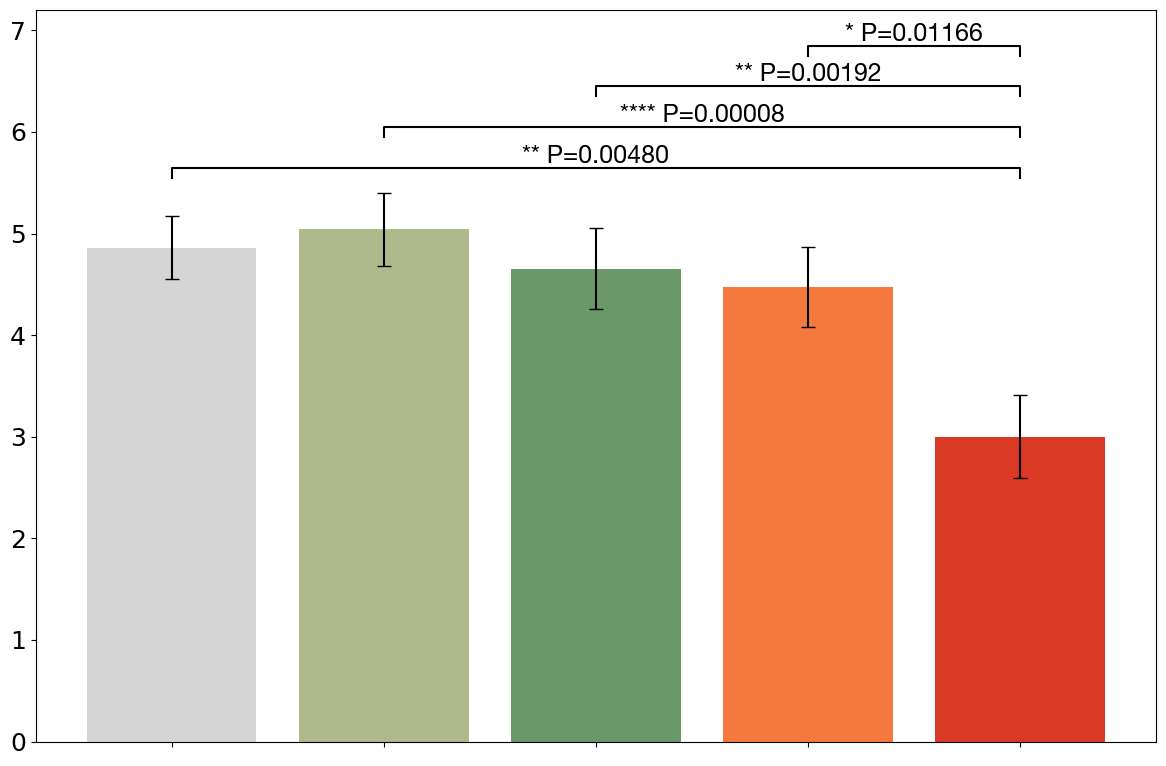

unsure

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.7297867546116228), pvalue=np.float64(6.637052063229967e-07))
honest summary => ShapiroResult(statistic=np.float64(0.49619621080806287), pvalue=np.float64(2.9483664708235045e-10))
honest chatbot => ShapiroResult(statistic=np.float64(0.6983676415201725), pvalue=np.float64(3.5142005981644956e-07))
misleading summary => ShapiroResult(statistic=np.float64(0.7116754246625281), pvalue=np.float64(4.3376162818253715e-07))
misleading chatbot => ShapiroResult(statistic=np.float64(0.7339265813980942), pvalue=np.float64(3.6769053495746604e-07))

KRUSKAL
KruskalResult(statistic=np.float64(5.751618793487051), pvalue=np.float64(0.21848129398348))

DUNN
          1         2         3         4         5
1  1.000000  0.054727  0.763451  0.917201  0.901136
2  0.054727  1.000000  0.111628  0.071386  0.037188
3  0.763451  0.111628  1.000000  0.844285  0.667911
4  0.917201  0.071386  0.844285  1.000000  0.818653
5  0.901136  0.037188  0.6

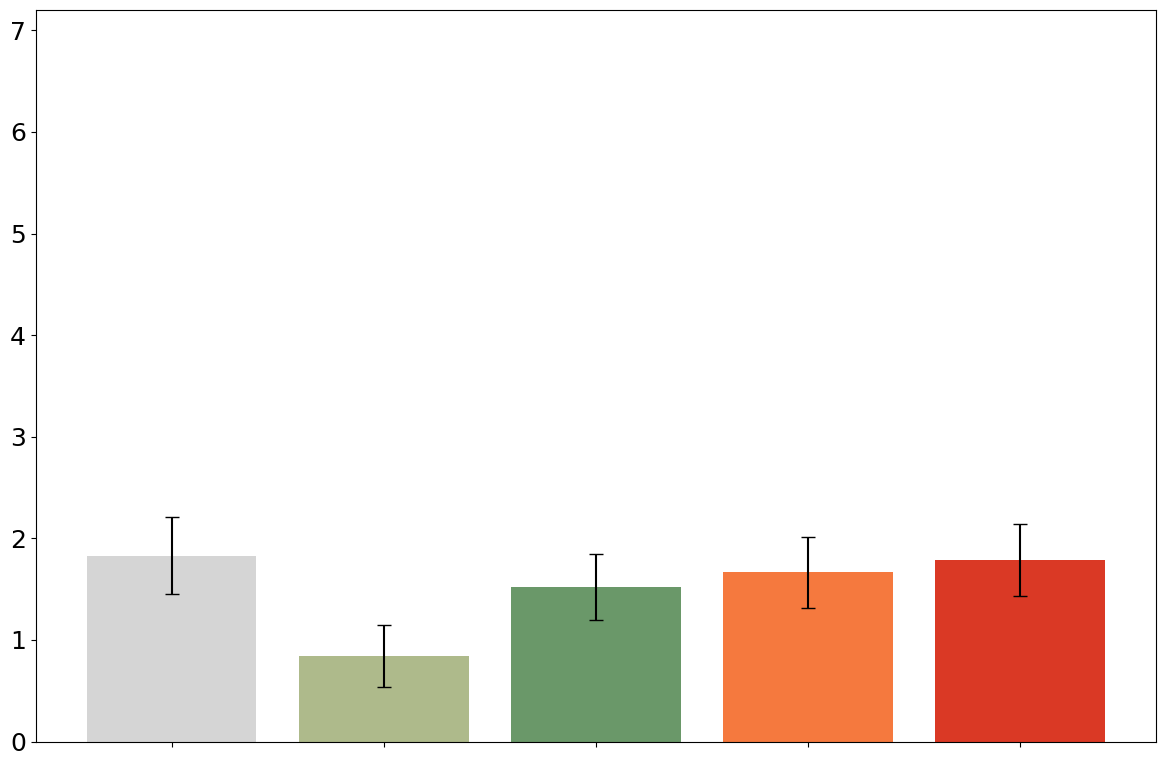

false

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.6792758033743235), pvalue=np.float64(1.0261103039999353e-07))
honest summary => ShapiroResult(statistic=np.float64(0.7155336277385933), pvalue=np.float64(2.956214262331277e-07))
honest chatbot => ShapiroResult(statistic=np.float64(0.7502432050494722), pvalue=np.float64(2.4781062447552906e-06))
misleading summary => ShapiroResult(statistic=np.float64(0.7324535928104225), pvalue=np.float64(9.530480728015797e-07))
misleading chatbot => ShapiroResult(statistic=np.float64(0.780691842397719), pvalue=np.float64(2.7467200769410272e-06))

KRUSKAL
KruskalResult(statistic=np.float64(14.847267120705553), pvalue=np.float64(0.0050287075009549185))

DUNN
          1         2         3         4         5
1  1.000000  0.311719  0.550014  0.029933  0.000630
2  0.311719  1.000000  0.692335  0.237749  0.015924
3  0.550014  0.692335  1.000000  0.121796  0.005782
4  0.029933  0.237749  0.121796  1.000000  0.237296
5  0.000630  0.015924  0

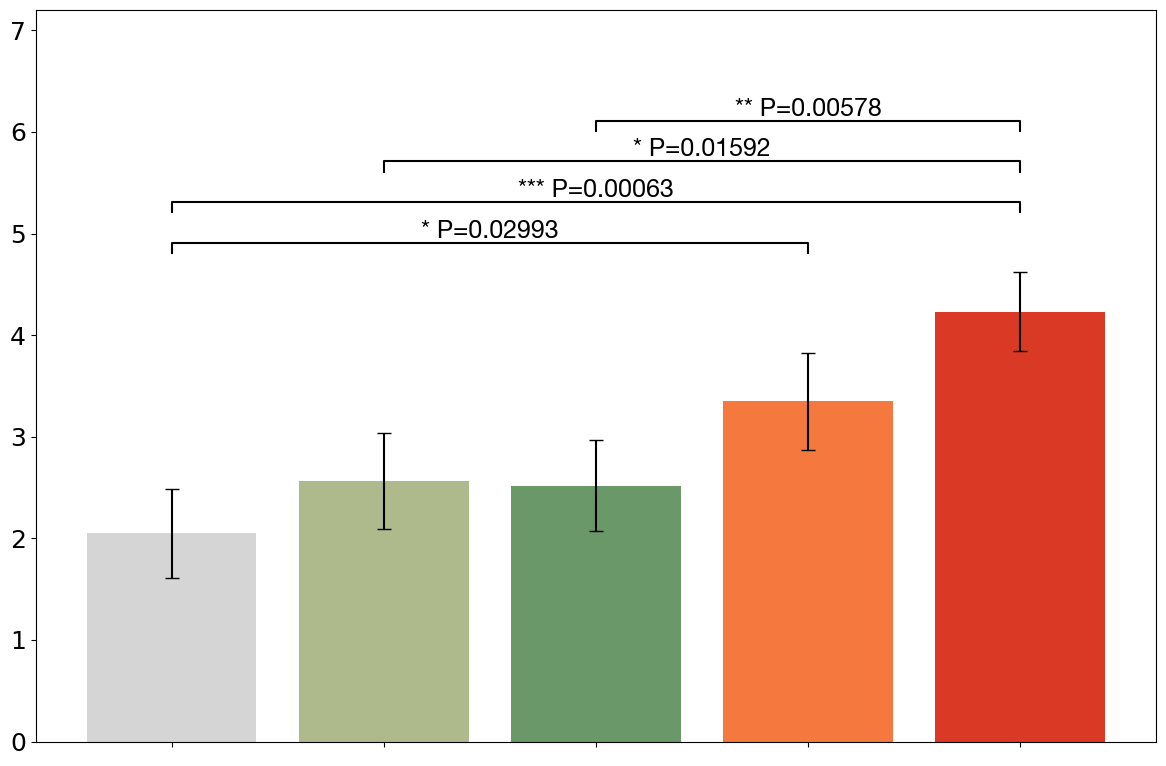

In [6]:
def sum_score(s, condition, type="false"):
    df = sources_df[s]
    real_ans = [f"{i}_qs-{s}-ans" for i in [*range(1,11)]]
    fake_ans = [f"{i}_qs-{s}-ans" for i in [*range(11,16)]]
    real_conf = [f"{i}_qs-{s}-conf" for i in [*range(1,11)]]
    fake_conf = [f"{i}_qs-{s}-conf" for i in [*range(11,16)]]
    
    yes = { "1": 1, "2": 0, "3": 0}
    unsure = { "1": 0, "2": 1, "3": 0}
    no = { "1": 0, "2": 0, "3": 1}
    
    types = {
        "true": [yes,no],
        "unsure": [unsure,unsure],
        "false": [no,yes]
    }
    
    df_real = df[df['condition'] == condition][[*real_ans, *real_conf]].replace(types[type][0])
    df_fake = df[df['condition'] == condition][[*fake_ans, *fake_conf]].replace(types[type][1])
    df_real['ans_sum'] = df_real[[f"{i}_qs-{s}-ans" for i in [*range(1,11)]]].sum(axis=1)
    df_fake['ans_sum'] = df_fake[[f"{i}_qs-{s}-ans" for i in [*range(11,16)]]].sum(axis=1)
    
    for i in range(1, 11):
        df_real[f'{i}-conf'] = df_real[f'{i}_qs-{s}-ans'] * df_real[f'{i}_qs-{s}-conf'].astype(int)
    
    for i in range(11, 16):
        df_fake[f'{i}-conf'] = df_fake[f'{i}_qs-{s}-ans'] * df_fake[f'{i}_qs-{s}-conf'].astype(int)
    
    df_real['conf_sum'] = df_real[[f"{i}-conf" for i in [*range(1,11)]]].sum(axis=1)
    df_fake['conf_sum'] = df_fake[[f"{i}-conf" for i in [*range(11,16)]]].sum(axis=1)
    
    df_real['conf'] = df_real['conf_sum'] / df_real['ans_sum'].replace(0, 1)
    df_fake['conf'] = df_fake['conf_sum'] / df_fake['ans_sum'].replace(0, 1)
    
    # print(df_fake)
    
    return [df_real['conf'], df_fake['conf'], df_real['conf_sum'] + df_fake['conf_sum'] / (df_real['ans_sum'] + df_fake['ans_sum']).replace(0, 1)]

def get_data(type="false"):
    overall_conf = {
        'control': [[], [], []],
        'honest summary': [[], [], []],
        'honest chatbot': [[], [], []],
        'misleading summary': [[], [], []],
        'misleading chatbot': [[], [], []]   
    }

    for source in sources:
        # print(source)
        for condition in conditions:
            score = sum_score(source, condition, type)
            for i in range(3):
                overall_conf[condition][i] += score[i].tolist()
            # overall[condition] += score.tolist()[0:24]
    
    # print(overall_conf)
        
    stats({ x: overall_conf[x][1] for x in overall_conf }, 7)

for type in ['true', 'unsure', 'false']:
    print(type)
    get_data(type)


SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.9180073018012331), pvalue=np.float64(0.00970100897563427))
honest summary => ShapiroResult(statistic=np.float64(0.8597034310389611), pvalue=np.float64(0.0002231039592985757))
honest chatbot => ShapiroResult(statistic=np.float64(0.9224136738844723), pvalue=np.float64(0.016742746680397925))
misleading summary => ShapiroResult(statistic=np.float64(0.9314772044304409), pvalue=np.float64(0.027753811640678496))
misleading chatbot => ShapiroResult(statistic=np.float64(0.9376424511954247), pvalue=np.float64(0.028816476751463427))

KRUSKAL
KruskalResult(statistic=np.float64(21.583707251785416), pvalue=np.float64(0.00024251555543416882))

DUNN
          1         2         3         4         5
1  1.000000  0.929707  0.516917  0.116600  0.000114
2  0.929707  1.000000  0.459752  0.095497  0.000070
3  0.516917  0.459752  1.000000  0.366113  0.001670
4  0.116600  0.095497  0.366113  1.000000  0.025542
5  0.000114  0.000070  0.001670  0.0

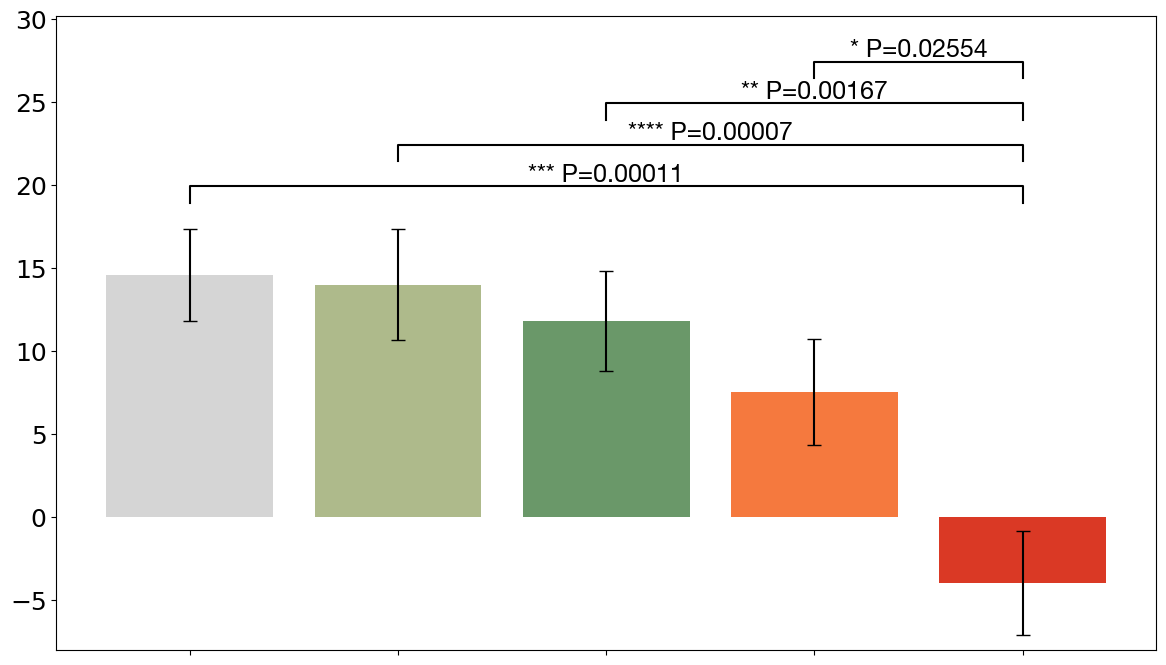

In [7]:
def sum_score(s, condition):
    df = sources_df[s]
    real_ans = [f"{i}_qs-{s}-ans" for i in [*range(1,11)]]
    fake_ans = [f"{i}_qs-{s}-ans" for i in [*range(11,16)]]
    real_conf = [f"{i}_qs-{s}-conf" for i in [*range(1,11)]]
    fake_conf = [f"{i}_qs-{s}-conf" for i in [*range(11,16)]]
    
    df_real = df[df['condition'] == condition][[*real_ans, *real_conf]].replace({ "1": 1, "2": 0, "3": -1})
    df_fake = df[df['condition'] == condition][[*fake_ans, *fake_conf]].replace({ "1": -1, "2": 0, "3": 1})
    
    for i in range(1, 11):
        df_real[f'{i}-score'] = df_real[f'{i}_qs-{s}-ans'] * df_real[f'{i}_qs-{s}-conf'].astype(int)
    
    for i in range(11, 16):
        df_fake[f'{i}-score'] = df_fake[f'{i}_qs-{s}-ans'] * df_fake[f'{i}_qs-{s}-conf'].astype(int)
    
    df_real['score'] = df_real[[f"{i}-score" for i in [*range(1,11)]]].sum(axis=1)
    df_fake['score'] = df_fake[[f"{i}-score" for i in [*range(11,16)]]].sum(axis=1)
    
    return [df_real['score'], df_fake['score'], df_real['score'] + df_fake['score']]

overall_score = {
    'control': [[], [], []],
    'honest summary': [[], [], []],
    'honest chatbot': [[], [], []],
    'misleading summary': [[], [], []],
    'misleading chatbot': [[], [], []]
}

for source in sources:
    # print(source)
    for condition in conditions:
        score = sum_score(source, condition)
        for i in range(3):
            overall_score[condition][i] += score[i].tolist()
        # overall[condition] += score.tolist()[0:24]

stats({ x: overall_score[x][1] for x in overall_score }, 30)

pm
true
control: \textit{M}=64.615;
honest summary: \textit{M}=45.000;
honest chatbot: \textit{M}=56.364;
misleading summary: \textit{M}=52.857;
misleading chatbot: \textit{M}=30.000;

unsure
control: \textit{M}=16.923;
honest summary: \textit{M}=10.000;
honest chatbot: \textit{M}=23.636;
misleading summary: \textit{M}=12.857;
misleading chatbot: \textit{M}=18.333;

false
control: \textit{M}=18.462;
honest summary: \textit{M}=45.000;
honest chatbot: \textit{M}=20.000;
misleading summary: \textit{M}=34.286;
misleading chatbot: \textit{M}=51.667;

drug
true
control: \textit{M}=76.667;
honest summary: \textit{M}=80.000;
honest chatbot: \textit{M}=71.667;
misleading summary: \textit{M}=63.333;
misleading chatbot: \textit{M}=35.714;

unsure
control: \textit{M}=10.000;
honest summary: \textit{M}=6.154;
honest chatbot: \textit{M}=15.000;
misleading summary: \textit{M}=13.333;
misleading chatbot: \textit{M}=8.571;

false
control: \textit{M}=13.333;
honest summary: \textit{M}=13.846;
honest cha

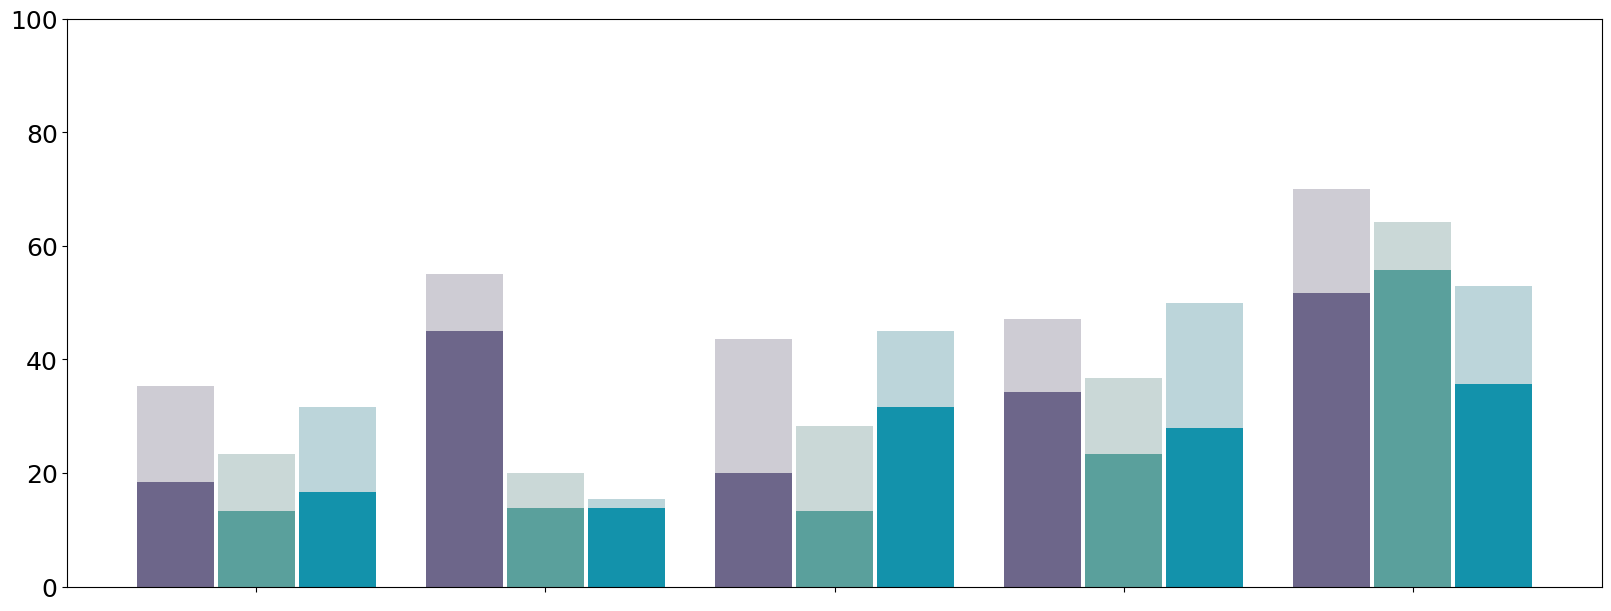

In [35]:
def get_data_by_source(type="false", source="drug"):
    overall = {
        'control': [[], [], []],
        'honest summary': [[], [], []],
        'honest chatbot': [[], [], []],
        'misleading summary': [[], [], []],
        'misleading chatbot': [[], [], []]   
    }

    for condition in conditions:
        score = sum_ans(source, condition, type)
        # print(condition, score[1].tolist())
        for i in range(3):
            overall[condition][i] += [x * 20 for x in score[i].tolist()]
        # overall[condition] += score.tolist()[0:24]
    # print()
        
    # stats({ x: overall[x][1] for x in overall })
    return { x: overall[x][1] for x in overall }


def g(source="pm"):
    cases = {
        'control': [],
        'honest summary': [],
        'honest chatbot': [],
        'misleading summary': [],
        'misleading chatbot': []
    }

    print(source)
    for type in ['true', 'unsure', 'false']:
        print(type)
        res = get_data_by_source(type, source)
        for c in conditions:
            cases[c].append(np.array(res[c]).mean())
            
            # print mean/std/error
            # print(f"{c}: m={np.array(res[c]).mean():.2f}, s.d.={np.array(res[c]).std():.2f}), err={np.array(res[c]).std() / np.sqrt(len(res[c])):.2f})")
            mean = np.array(res[c]).mean()
            std = np.array(res[c]).std()
            error = std / np.sqrt(len(res[c]))
            print(f"{c}: \\textit{{M}}={"{:.3f}".format(mean)};")
        print("")
    
    return cases

ordered_labels = ['', '', '', '', '']

# X positions
x_pos = np.arange(len(conditions))
width = 0.25  # the width of the bars
multiplier = 0

r0 = [[], [], []]
r1 = [[], [], []]
r2 = [[], [], []]

pm, drug, shoplift = g("pm"), g("drug"), g("shoplift")
    
for c in conditions:
    for j in range(3):
        r0[j].append(pm[c][j])
        r1[j].append(drug[c][j])
        r2[j].append(shoplift[c][j])
            
r = [[np.array(i) for i in r0], [np.array(i) for i in r1], [np.array(i) for i in r2]]

# print(r0[0])
# print(r0[0] + r0[1])

fig, ax = plt.subplots(layout='constrained', figsize=(16, 6))

width = 0.28  # the width of the bars
multiplier = 0
    
i = 0
colors = ["#6D668A", "#5AA09C", "#1392AB"]
colors_light = ["#CECCD4", "#CAD8D7", '#BCD5DA']
for x in [r0, r1, r2]:
    offset = width * multiplier
    ax.bar(x_pos + offset, x[2], width - 0.015, color=colors[i])
    ax.bar(x_pos + offset, x[1], width - 0.015, bottom=x[2], color=colors_light[i])
    # ax.bar(x_pos + offset, x[0], width - 0.01, bottom=np.array(x[2]) + np.array(x[1]), color='#6D668A')
    multiplier += 1
    i += 1

ax.set_xticks(x_pos + width, ['', '', '', '', ''])
ax.set_ylim(0, 100)
    
# ax.ylim(0, 5.2)
# ax.tight_layout()
plt.show()